In [1]:
# references:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://github.com/fastai/course22p2/blob/master/nbs/08_autoencoder.ipynb
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/autoencoders/vae.py

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

In [3]:
data_train = torchvision.datasets.FashionMNIST(root=".\data", train = True, transform=ToTensor(), download=True)

In [4]:
data_test = torchvision.datasets.FashionMNIST(root=".\data", train = False, transform=ToTensor(), download=True)

In [5]:
data_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .\data
    Split: Train
    StandardTransform
Transform: ToTensor()

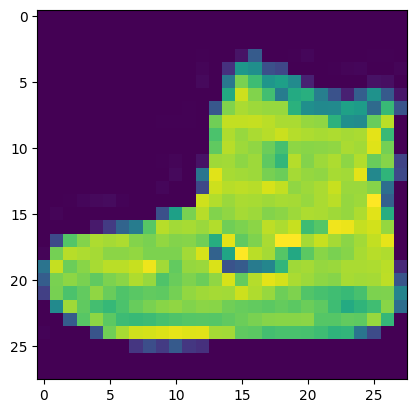

In [6]:
plt.imshow(data_train[0][0].squeeze())

In [7]:
dl_train = DataLoader(data_train, batch_size=64, shuffle=True, num_workers=4)
dl_test = DataLoader(data_test, batch_size=64, shuffle=True, num_workers=4)

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [9]:
xb, yb = next(iter(dl_train))

'Sneaker'

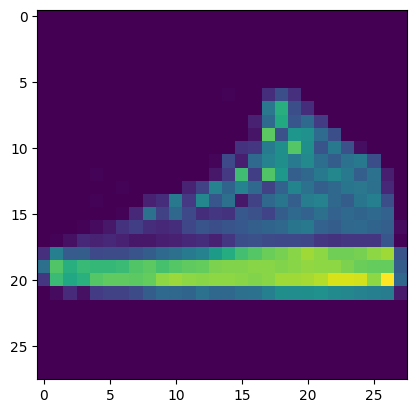

In [10]:
#plt.imshow(xb[0].squeeze())
plt.imshow(xb[0].permute(1,2,0))
labels_map[yb[0].item()]

In [11]:
xb[0].shape

torch.Size([1, 28, 28])

In [12]:
conv = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=3//2) # 14*14
conv(xb[0]).shape

torch.Size([4, 14, 14])

In [13]:
vae = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=3//2), # 14*14
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=3//2), # 7*7    
    nn.ReLU(),
)

In [14]:
vae(xb).shape

torch.Size([64, 8, 7, 7])

In [15]:
conv_in = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
conv_in(xb[0]).shape

torch.Size([32, 28, 28])

In [16]:
class MyVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # (conv_in)
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 28, 28
            
            # (down_block_0)
            # (norm1)
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (conv1)
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (norm2): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (dropout): 
            nn.Dropout(p=0.5, inplace=False),
            # (conv2): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),
            # (downsamplers)(conv): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #14, 14


            
            # (down_block_1)
            # (norm1)
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (conv1)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (norm2): 
            nn.GroupNorm(8, 64, eps=1e-06, affine=True),
            # (dropout): 
            nn.Dropout(p=0.5, inplace=False),
            # (conv2): 
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),
            # (conv_shortcut): 
            #nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),            
            # (downsamplers)(conv): 
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #7, 7

            # (conv_norm_out): 
            nn.GroupNorm(16, 64, eps=1e-06, affine=True),
            # (conv_act): 
            nn.SiLU(),
            # (conv_out): 
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

            #nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=3//2), # 14*14
            #nn.ReLU(),
            #nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=3//2), # 7*7    
            #nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            #(conv_in): 
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

            #(norm1): 
            nn.GroupNorm(16, 64, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(norm2): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            #(dropout): 
            nn.Dropout(p=0.5, inplace=False),
            #(conv2): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(nonlinearity): 
            nn.SiLU(),      

            #(upsamplers): 
            nn.Upsample(scale_factor=2, mode='nearest'), # 14,14

            #(norm1): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(norm2): 
            nn.GroupNorm(8, 16, eps=1e-06, affine=True),
            #(dropout): 
            nn.Dropout(p=0.5, inplace=False),
            #(conv2): 
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(nonlinearity): 
            nn.SiLU(),      

            #(upsamplers): 
            nn.Upsample(scale_factor=2, mode='nearest'),  # 16, 28, 28          

            #(norm1): 
            nn.GroupNorm(8, 16, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  

            nn.Sigmoid()
        )
        
    def forward(self, xb, yb):
        x = self.encoder(xb)
        #print("current:",x.shape)
        x = self.decoder(x)
        #print("current decoder:",x.shape)
        #x = x.flatten(start_dim=1).mean(dim=1, keepdim=True)
        #print(x.shape, xb.shape)
        return x, F.mse_loss(x, xb)

In [17]:
myVAE = MyVAE()

In [18]:
out, loss = myVAE(xb, yb)

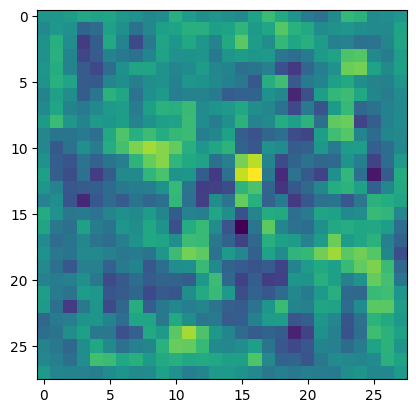

In [19]:
plt.imshow(out[0].permute(1,2,0).detach())

In [20]:
opt = optim.SGD(myVAE.parameters(), lr= 1e-3)

In [21]:
def train(epochs = 1, opt = opt, device="cuda", steps = 1000):
    myVAE.to(device)
    myVAE.train()
    step = 0
    losses = 0
    all_losses=[]
    
    for xb, yb in dl_train:
        xb=xb.to(device)
        yb.to(device)
        out,loss = myVAE(xb, yb)
        loss.backward()
        with torch.no_grad():
            opt.step()
            opt.zero_grad()
            
        step = step + 1
        losses += loss

        if step % 100 == 0:
            print(f"losses:{losses/100}")
            all_losses+=[losses.detach().cpu()/100]
            losses = 0

        if steps !=0 and step > steps:
            break

    plt.plot(range(len(all_losses)), all_losses)

losses:0.016622677445411682
losses:0.016530493274331093
losses:0.016684887930750847
losses:0.016766374930739403
losses:0.01657492108643055
losses:0.016818653792142868
losses:0.016625601798295975
losses:0.016708197072148323
losses:0.016493821516633034
losses:0.016571015119552612
losses:0.01659400202333927
losses:0.01667516678571701
losses:0.016692232340574265
losses:0.01661943644285202
losses:0.016631968319416046
losses:0.01650312729179859
losses:0.016761453822255135
losses:0.01656368188560009
losses:0.016717717051506042
losses:0.01682889275252819
losses:0.01659672148525715
losses:0.016561293974518776
losses:0.016653291881084442
losses:0.016670580953359604
losses:0.016564708203077316
losses:0.016590965911746025
losses:0.016569070518016815
losses:0.016605397686362267
losses:0.01657361350953579
losses:0.016596337780356407
losses:0.01670215278863907
losses:0.01653098873794079
losses:0.016512155532836914
losses:0.01669163815677166
losses:0.016667183488607407
losses:0.016600271686911583
loss

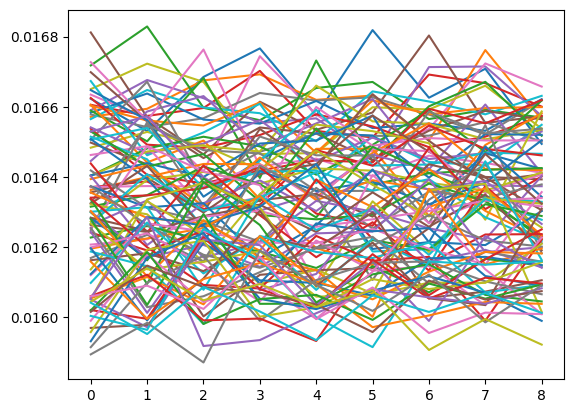

In [474]:
for _ in range(100):
    train(opt=opt,steps=0)


In [22]:
def show_images(total_images, xb_eval, out):
    total_images = total_images*2
    n_cols = 8
    n_rows = total_images//n_cols
    fig, axes = plt.subplots(
            nrows=n_rows, ncols=n_cols,
            figsize=(n_cols * 3, n_rows * 3))

    for ii in range(total_images//2):
        cur_ax = axes.flatten()[ii*2]
        cur_ax.imshow(xb_eval[ii].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray') 
        cur_ax = axes.flatten()[ii*2+1]
        cur_ax.imshow(out[ii].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray') 

In [23]:
myVAE = torch.load("checkpoint10.pt")
myVAE.eval()

MyVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 32, eps=1e-06, affine=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GroupNorm(8, 32, eps=1e-06, affine=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): SiLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): GroupNorm(8, 32, eps=1e-06, affine=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): GroupNorm(8, 64, eps=1e-06, affine=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): SiLU()
    (14): SiLU()
    (15): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (16): GroupNorm(16, 64, eps=1e-06, affine=True)
    (17): SiLU()
    (18): Conv2d(64, 3, kernel_size=(3, 3),

loss:0.011248994618654251


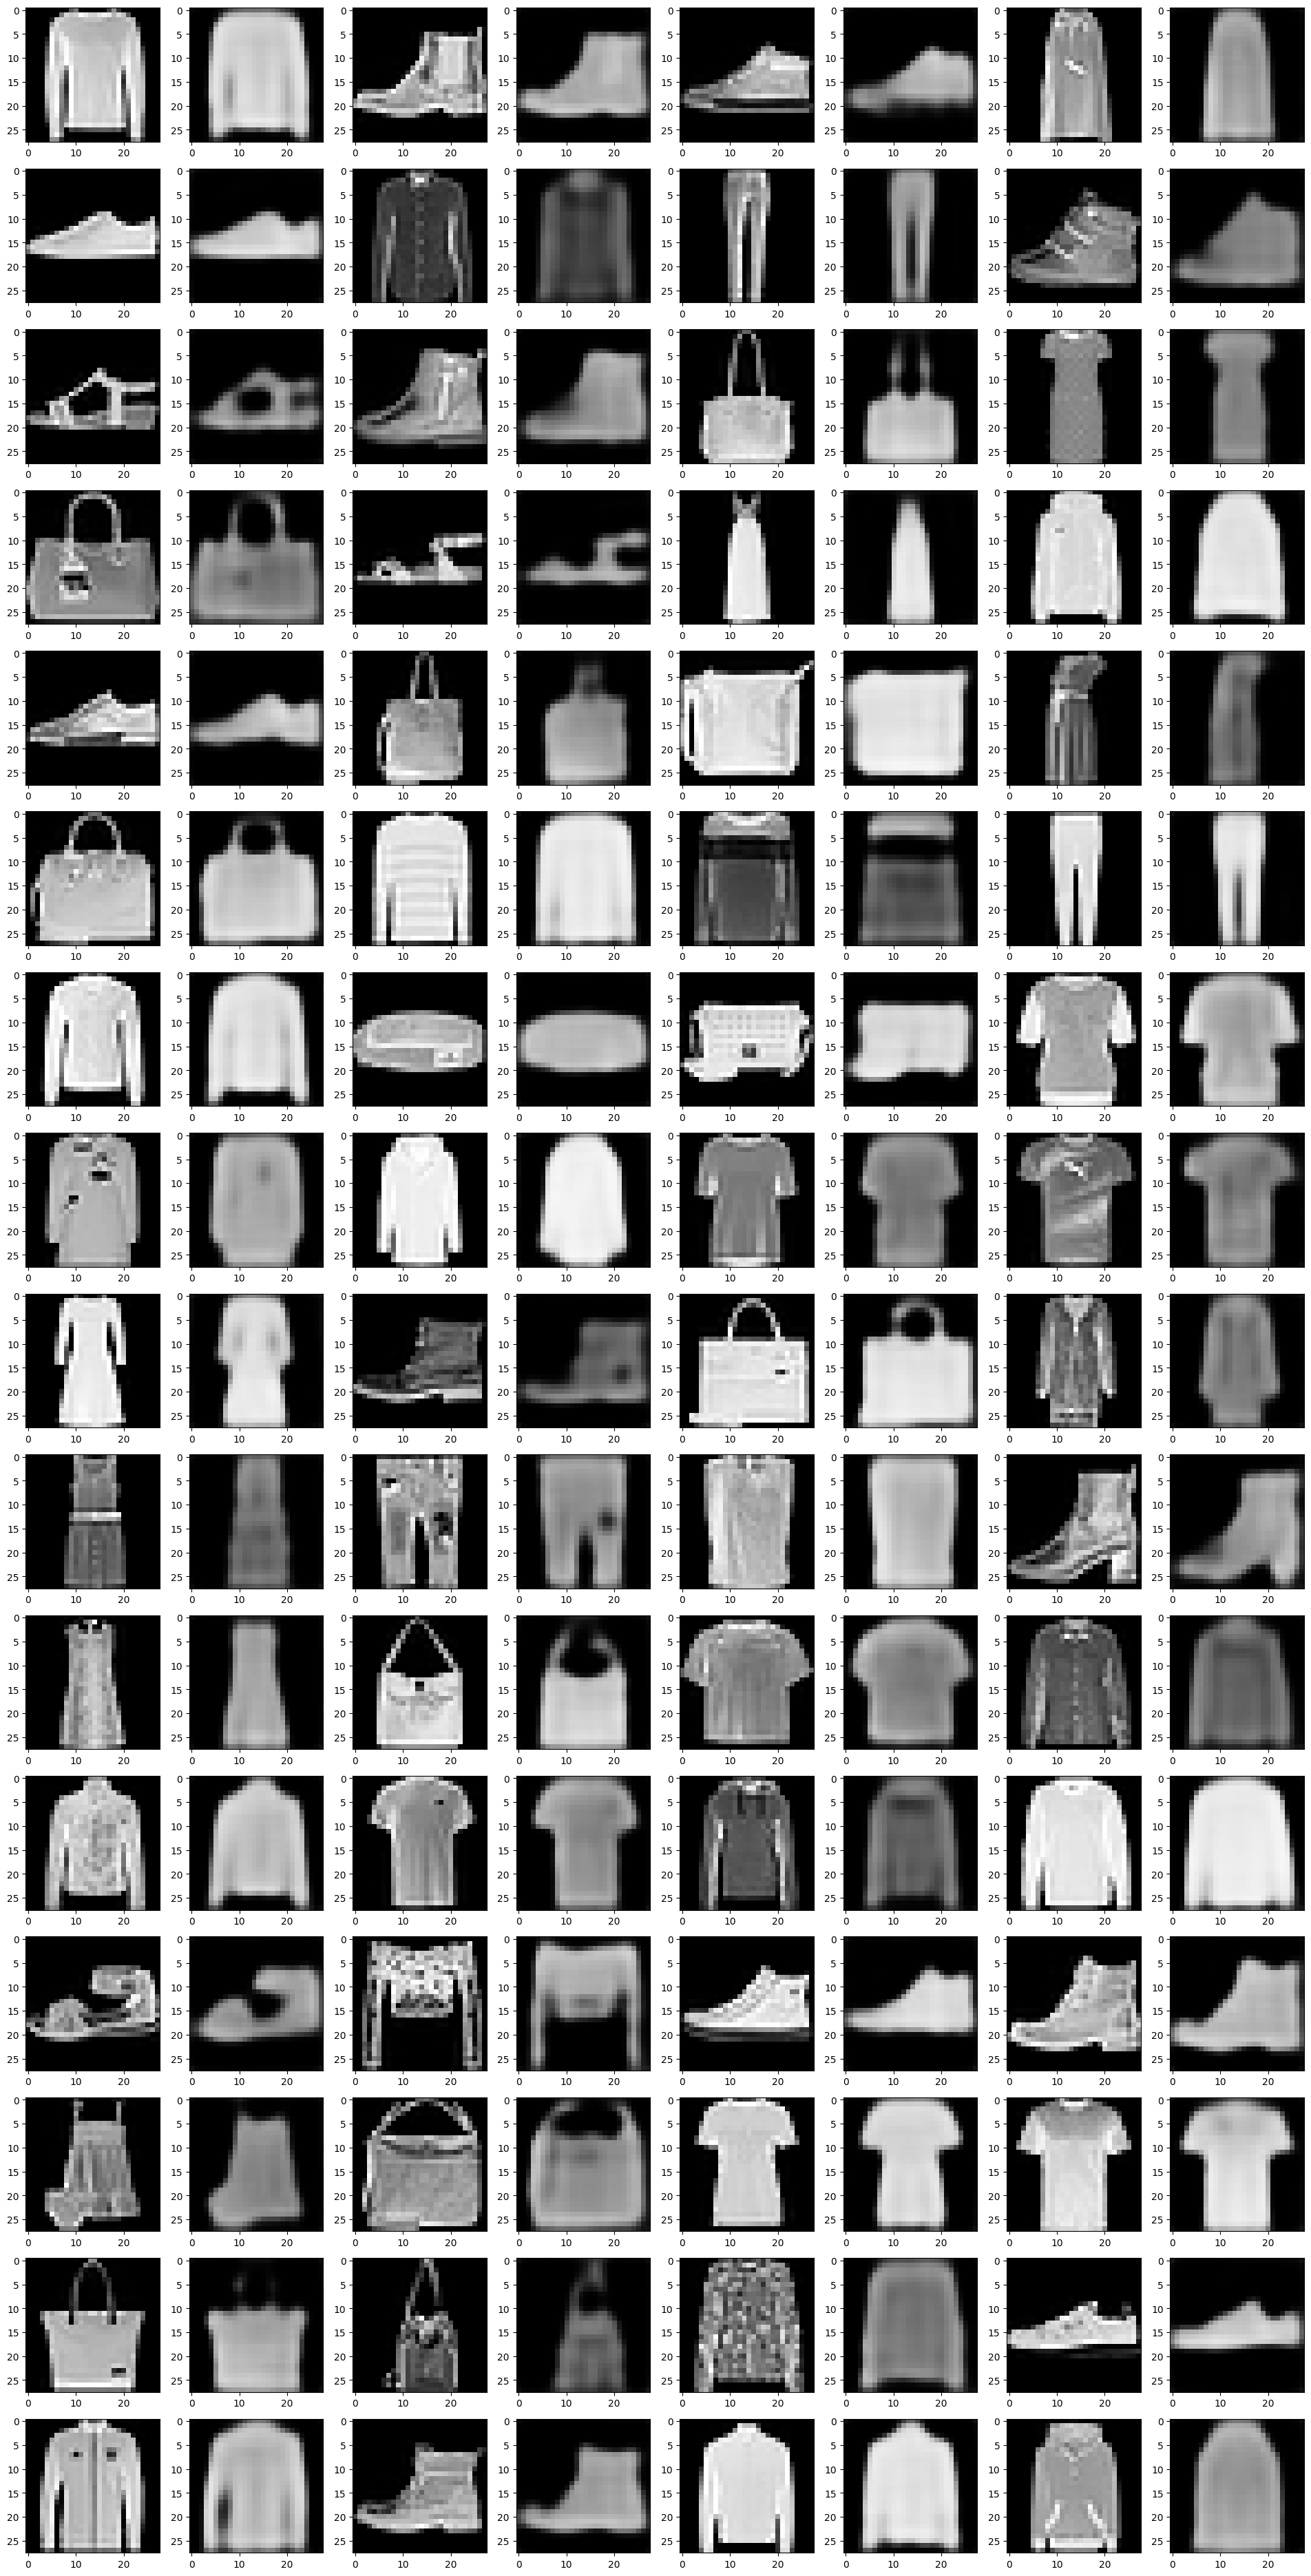

In [25]:
def eval():
    xb_eval, yb_eval = next(iter(dl_test))
    out, loss = myVAE(xb_eval.to(device), yb.to(device))
    print(f"loss:{loss}")
    idx = 0
    #plt.imshow(xb_eval[idx].permute(1,2,0))
    #plt.imshow(out[idx].detach().cpu().permute(1,2,0))

    total_images = xb_eval.shape[0]
    #show_images(total_images, xb_eval)
    #show_images(total_images, out.detach().cpu())
    show_images(total_images, xb_eval, out.detach().cpu())

device="cuda"
eval()

In [26]:
#torch.save(myVAE, "checkpoint10.pt")

In [27]:
myVAE2 = torch.load("checkpoint10.pt")
myVAE2.eval()

MyVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 32, eps=1e-06, affine=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GroupNorm(8, 32, eps=1e-06, affine=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): SiLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): GroupNorm(8, 32, eps=1e-06, affine=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): GroupNorm(8, 64, eps=1e-06, affine=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): SiLU()
    (14): SiLU()
    (15): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (16): GroupNorm(16, 64, eps=1e-06, affine=True)
    (17): SiLU()
    (18): Conv2d(64, 3, kernel_size=(3, 3),

In [28]:
out, loss = myVAE2(xb.to(device), yb.to(device))

In [29]:
idx = 8

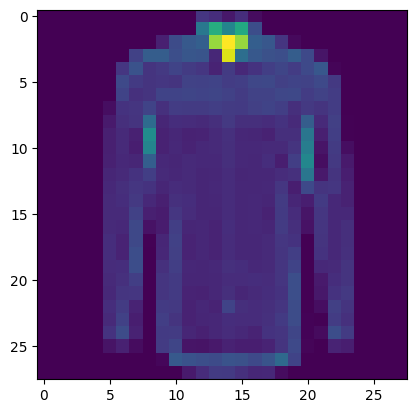

In [30]:
plt.imshow(xb[idx].permute(1,2,0))

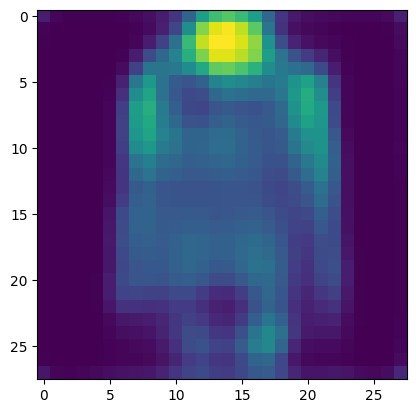

In [31]:
plt.imshow(out[idx].permute(1,2,0).detach().cpu())